---
layout:     post
title:      K-Nearest Neighbors algorithm on Iris dataset
subtitle:   Workflow of a basic classification task
date:       2021-06-02
author:     Martin Beneš
header-img: knn_iris_data/Iris_versicolor.jpg
catalog:    true
katex:      true
tags:
    - machinelearning
    - sklearn
    - classification
    - knn
    - crossvalidation
    - visualization
    - iris
---

Let's go through a basic steps of a classification workflow on species of plants in popular dataset *iris*. For implementation we shall use Python and a library *scikit-learn* (`sklearn`).

To score the accuracy we will see a holdout and a cross-validation.

## Data

The dataset `iris` is very popular amongst machine learners in example tasks such as this one. For this reason it is also present directly in the `sklearn` package.

In [4]:
# load iris dataset

from sklearn.datasets import load_iris
iris = load_iris()

In the dataset there are three different species of genus Iris: I. setosa, I. versicolor and I. virginica. We are given 150 plants (50 per species), where for each of the samples we measured width and length of petal and sepal of the flower.

<img src="knn_iris_data/petal_sepal.png" width = "50%"/>

In [5]:
print(iris.data.shape, iris.target.shape) # iris data and labels

print(iris.target_names) # names of labels

print(iris.feature_names) # names of attributes

(150, 4) (150,)
['setosa' 'versicolor' 'virginica']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


The task will be to determine the species for a sample based on the dimensions of its petals and sepals.

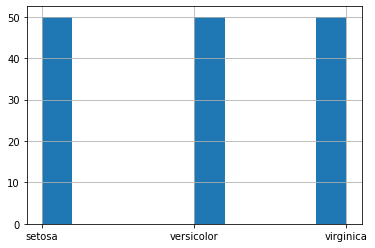

In [6]:
# plot group distribution

import pandas as pd
import matplotlib.pyplot as plt
target_str = pd.Series(iris.target).apply(lambda i: iris.target_names[i])
ax = target_str.hist()

Fortunately `iris` dataset is balanced, it has the same number of samples for each species, as you can see in the bar chart above, Balanced dataset makes it simple to proceed directly to the classification phase.

In opposite case we would have to do additional steps to reduce the negative effects. Such problem is called *imbalanced classification*.

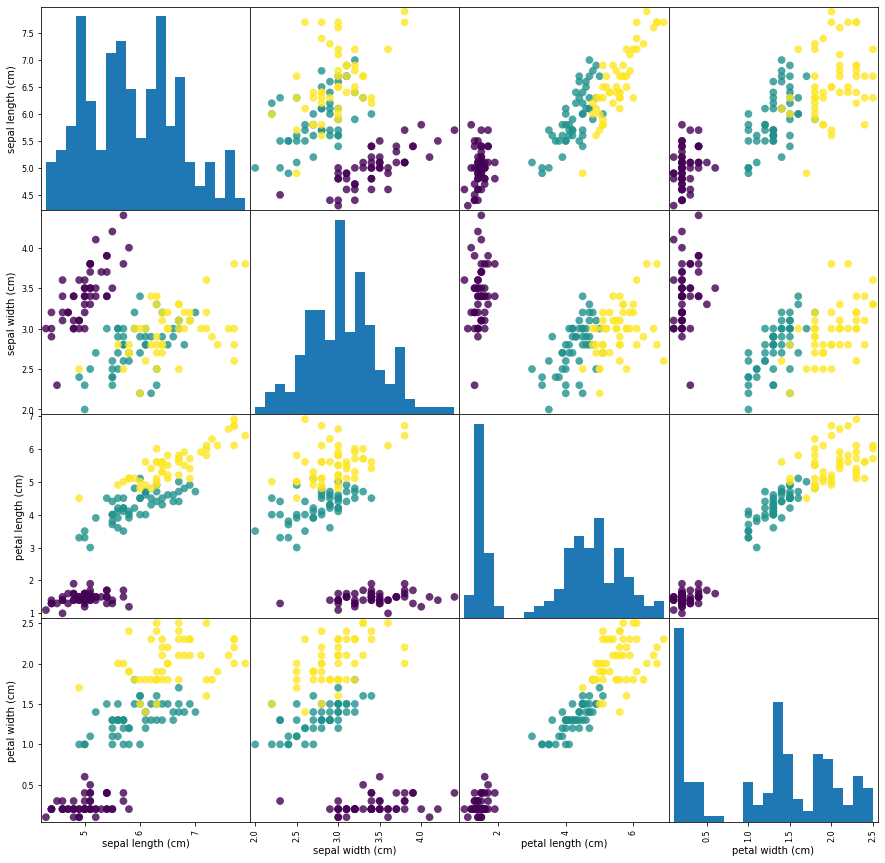

In [23]:
# iris as data frame

iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
# create a scatter matrix from the dataframe, color by target

ax = pd.plotting.scatter_matrix(iris_df, c=iris.target,
    figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, s=60, alpha=.8)

In the plot we can see domains of values as well as the distributions of each of the attribute. It is also possible to compare groups in scatter plots over all pairs of attributes. From those it seems that groups are well separated, two of the groups slightly overlap.

## Train-test split

The dataset is split onto train and test sets in ratio 75:25.

* Train set is used for training.
* Test set is used for estimation of model performance to find out, whether model generalizes well.

This method is sometimes also called *holdout*.


In [7]:
# train test split

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(iris.data, iris.target, train_size=.75, random_state=12345)

print(xtrain.shape, ytrain.shape) # dimension of train set

print(xtest.shape, ytest.shape) # dimension of test set

(112, 4) (112,)
(38, 4) (38,)


## kNN model

Intuitively the idea of the kNN (k-nearest neighbors) model is 

> Majority of the most similar samples are class A, so the sample is also class A.

The black point in the plot below would be classified as species versicolor.

<img src="knn_iris_data/knn_points.png" />

However, we should be asking following questions now.

* How do you define "similar samples"?
* How many of these similar samples should we take?

Fortunately the math of the model is implemented and hidden inside the package `sklearn`, so we do not have to reimplement it, just understand, what it does.

In the plot before, we are using **Euclidean metric** *as crow flies*, which is intuitive. Its mathematical formula is

$$d(x,y) = \sqrt{(x[1]-y[1])^2 + (x[2]-y[2])^2 + ... } = \sqrt{\sum_{i=1}^D(x[i]-y[i])^2}$$

However there are cases, when we might need something else:

* Many cities (especially in US, such as New York City) have orthogonal grid of streets. If you travel from A to B, you travel separately in x and y. Such distance metric is called **Manhattan metric**.

$$d(x,y) = (x[1]-y[1]) + (x[2]-y[2]) + ... = \sum_{i=1}^D(x[i]-y[i])$$

* Similarity of geographic coordinates is done with spheric distance, rather than planear. Most common metric is **great-circle distance**, usually computed with *haversine formula*.

$$g = (\text{longitude}~\lambda_g, \text{latitude}~\phi_g)$$

$$d(x,y) = 2~\text{arcsin}\sqrt{\text{sin}^2\Big(\frac{\Delta\phi}{2}\Big) + \cos{(x_\phi)}\cos{(y_\phi)}\text{sin}^2\Big(\frac{\Delta\lambda}{2}\Big)}$$

<!--**Similar samples** have similar values in its attributes. Imagine two points in a plane: the closer they are, more similar their x and y coordinates are. And vice versa, further the points are from each other, more different their x and y coordinates become. Similarity is the inverse of distance.

In kNN we work with minimal distance. Selection of how to compute distance (*distance metric*) is not so trivial, the most intuitive and the one we shall use is the "as bird flies", called **Euclidean distance**. Its mathematical equation is-->



All the examples above were done with two dimensions, but keep in mind that in our task we operate in 4-dimensional space - our data attributes. With different dataset it can be much more.

Selection of the **number of similar samples** will be discussed later in the section [Hyperparameter tuning](#hyperparameter-tuning). For now we shall use 5.

## Train the model

We define kNN classifier with class `KNeighborsClassifier`, hyperparameter `n_neighbors` value is 5.

In [10]:
# create a knn, k = 5

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

For training the model only train set is used.

In [14]:
# fit to the train set

knn.fit(xtrain, ytrain)

Classifier is trained now, information about the train data has been extracted and save inside the object `knn`. Method `fit()` is present in all the *estimators* of the package `scikit-learn`. Documentation defines estimator as

> An object that fits a model based on some training data and is capable of inferring some properties on new data. It can be, for instance, a classifier or a regressor. All estimators implement the `fit()` method.

The method `fit()` works *in situ* (latin for *in place*), i.e. changes the inner state of the object.

## Predict

Fitted model is now able to receive the input data and produce predictions of the labels. We will predict labels for both train and test data.

In [15]:
ytrain_pred = knn.predict(xtrain) # predict on train set

ytest_pred = knn.predict(xtest) # predict on test set

## Evaluation

Comparison of predicted and true label can tell us valuable information about how well our model performs. The simplest performance statistic is the ratio of correct predictions, called *accuracy*.

$$\text{accuracy} = \frac{\#~\text{correct predictions}}{\#~\text{predictions}}$$

The complement of accuracy is misclassification.

$$\text{misclassification} = 1 - \text{accuracy} = \frac{\#~\text{incorrect predictions}}{\#~\text{predictions}}$$

In [16]:
# accuracy

acc_train = (ytrain == ytrain_pred).mean()
acc_test = (ytest == ytest_pred).mean()
print(f"Train set: {acc_train}")
print(f"Test set: {acc_test}")

Train set: 0.9642857142857143
Test set: 0.9736842105263158


The accuracy of the classifier on the train set should be the same or a bit better than on the test set. If the test accuracy is much worse, we are overfitting the model and have to change parameters. In kNN, the value of `n_neighbors` is the key to achieve the best results, more about it in the section [Hyperparameter tuning](#hyperparameter-tuning).

To evaluate, whether our model performs well, its performance is compared to other models. We usually start with dummy models.

**Most frequent** model always predicts the label that occur the most in our dataset. If the dataset is balanced such as `iris`, we choose one of the classes.

In [29]:
# most frequent model

import numpy as np
ytest_most_frequent_pred = np.zeros(iris.target.shape[0])
acc_most_frequent = (iris.target == ytest_most_frequent_pred).mean()
print(f"Most frequent accuracy: {acc_most_frequent}")

Most frequent accuracy: 0.3333333333333333


**Stratified** model assigns random label based on ratio of the labels in the dataset. In case of `iris`, the probabilities of each species are equal.

In [30]:
# stratified model

ytest_stratified_pred = np.random.randint(0,3,iris.target.shape[0])
acc_stratified = (iris.target == ytest_stratified_pred).mean()
print(f"Stratified accuracy: {acc_most_frequent}")

Stratified accuracy: 0.3333333333333333


Accuracy of kNN is thus much better compared to these naive classifiers. We could now continue with comparison with other machine learning classification models.

More complex method to evaluate the performance of a classifier is constructing a *confusion matrix*, that shows not only accuracies for each of the classes (labels), but what classes is the classifier most confused about.

In [31]:
# confusion matrix for train set

from sklearn.metrics import confusion_matrix,plot_confusion_matrix
cM_train = confusion_matrix(ytrain, ytrain_pred)
cM_train

array([[37,  0,  0],
       [ 0, 34,  2],
       [ 0,  2, 37]], dtype=int64)

On the train set, two samples of versicolor were classified as virginica and two samples of virginica as versicolor. All the setosa samples were classified correctly.

The accuracy of the prediction can be derived from the confusion matrix as sum of the matrix diagonal over sum of whole matrix.

In [32]:
# train set accuracy from confusion matrix

np.diag(cM_train).sum() / cM_train.sum()

0.9642857142857143

Confusion matrix can be used to get other interesting statistics about the prediction, such as sensitivity or true positive rate (TPR), specificity or true negative rate (TNR), positive predictive value (PPV) and negative predictive value (NPV). More about these in another article.

We can also visualize confusion matrix in form of heatmap.

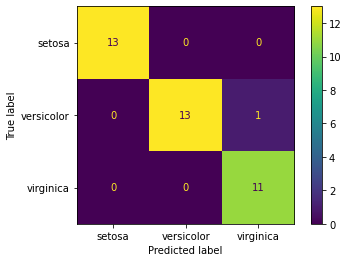

In [33]:
# plot test set confusion matrix as heatmap

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(knn, xtest, ytest, display_labels=iris.target_names)
plt.show()

On the test set, classifier worked flawlessly on setosas and virginicas. One versicolor sample was mistakenly classified as virginica.

## Hyperparameter tuning

Hyperparameters are parameters of the model, that are not subject of model training. As they have significant impact on the model prediction, we want to set them to the best value possible to maximize the prediction success of the model. For kNN the hyperparameter is the number of neighbors used for prediction, `n_neighbors`.

We can find hyperparameters in many other machine learning models such as k-means (number of clusters `k`), Elastic net (regularization `lambda1` and `lambda2`) or neural networks (structure of network, used activation functions, dropout probabilities, number of epochs, batch size, ...).

We start by creating a new model without specifying the hyperparameter value.

In [34]:
# create a knn

from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier()

The procedure to optimize the hyperparameter value is based on a simple algorithm:

* *Choose a value*.
* Evaluate the *objective function*.
* If it is better than the best seen so far, remember this point instead.

The two configurable parts of this procedure are strategy for choosing a value and objective function. Two strategies that we will compare are *random choice* and *grid searching*, but there is many other heuristics such as hillclimbing, genetic algorithms or particle swarm. Neither of the two presented strategies guarrantee to return the optimal value though.

The plot below presents both studied strategies, the red points are the best solutions found by each of the method.

<img src="knn_iris_data/grid_random.png" />

Objective function is a way to score, how good each value is and to compare two hyperparameter values. In our case, we will use *accuracy* of the model prediction.

To maintain independence of test set, it can not be used for optimization of the hyperparameters. We will split the training data into two parts, where one is still called train set and the other is validation set and we use it to calculate the accuracy over different `n_neighbors` values on a model trained with train set. This split is done inside `sklearn` automatically.

Randomized search means random choosing of the `n_neighbors` value. We specify the domain of the parameter and the number of iterations.

In [35]:
# tune hyperparameter k

from sklearn.model_selection import RandomizedSearchCV
distributions = dict(n_neighbors=list(range(1,50)))
clf = RandomizedSearchCV(knn2, distributions, random_state=0, n_iter = 10)
# run 

search = clf.fit(xtrain, ytrain)
search.best_params_['n_neighbors']

5

The best configuration of hyperparameter `n_neighbors` acquired with randomized search is 5.

Grid search means we are looking for the `n_neighbors` value in a regular grid over the domain of the objective function. For the grid search we have to specify the grid.

In [36]:
# tune hyperparameter k

from sklearn.model_selection import GridSearchCV
parameters = dict(n_neighbors=list(range(1,50)))
clf2 = GridSearchCV(knn2, parameters)
# run 

search2 = clf2.fit(xtrain, ytrain)
search2.best_params_['n_neighbors']

3

The best configuration of hyperparameter `n_neighbors` acquired with grid search is 3.

In [9]:
# classify with k = 3

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
# predict train and test

ytrain_pred = knn.predict(xtrain)
ytest_pred = knn.predict(xtest)
# accuracies

print((ytrain_pred == ytrain).mean())
print((ytest_pred == ytest).mean())

0.9642857142857143
0.9736842105263158


The accuracy for `n_neighbors` 3 and 5 is identical.

It is also possible to make a plot of objective function over the hyperparameter `n_neighbors` for the misclassifications on train and test sets, which gives us a better insight, whether the parameter values returned by the strategies seem to be the optimal ones.

In [40]:
# accuracy on train and test sets over parameter values

acc_train,acc_test = [],[]
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    acc_train.append((ytrain != knn.predict(xtrain)).mean())
    acc_test.append((ytest != knn.predict(xtest)).mean())

We can see that as `n_neighbors` grow, train set misclassification grows. As for test classification, for 1-4 it goes down, then it stays the same and after 40 it starts growing. Hyperparameter value 1 means the model is overfitted, if we set too high value (> 20), the model is getting underfitted. Both of the strategies returned reasonable value.

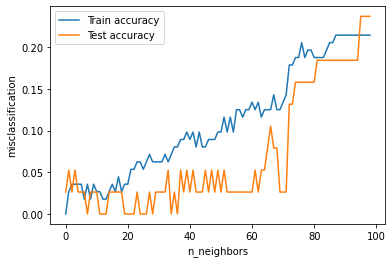

In [43]:
# plot accuracies over n_neighbors

plt.plot(acc_train, label='Train accuracy')
plt.plot(acc_test, label='Test accuracy')
plt.legend()
plt.xlabel("n_neighbors")
plt.ylabel("misclassification")
plt.show()

## Summary

In this article, we classified `iris` dataset using k-nearest neighbors. We presented the dataset, reasoned usage of holdout, explained the principle of kNN classifier and evaluate the prediction of the model using accuracy / misclassification and confusion matrix against the dummy models: stratified and the most common. The hyperparameter `n_neighbors` was tuned using cross-validation with grid search and randomized search.

The best accuracy achieved was 97.37 % on test data and 96.43 % on train data for `n_neighbors` 3 or 5.

## References

- Andreas C. Müller & Sarah Guido: Introduction to Machine Learning with Python (2017). ISBN: <a href="https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/">978-1-449-36941-5</a>.
- Jake VanderPlas: In Depth: Principal Component Analysis. <a href="https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html">https://jakevdp.github.io/</a>
- Tzu-Chi Lin: Day 3 - K-Nearest Neighbors and Bias-Variance Tradeoff. <a href="https://medium.com/30-days-of-machine-learning/day-3-k-nearest-neighbors-and-bias-variance-tradeoff-75f84d515bdb">https://medium.com/</a>
- Jeremy Jordan: Hyperparameter tuning for machine learning models. <a href="https://www.jeremyjordan.me/hyperparameter-tuning/">https://www.jeremyjordan.me/</a>
- Scikit-learn: Machine Learning in Python. <a href="https://scikit-learn.org/">https://scikit-learn.org/</a>
- Danielle Langlois: Iris versicolor photo. <a href="https://commons.wikimedia.org/wiki/File:Iris_versicolor_3.jpg">Iris versicolor 3.jpg</a>
- Black And White Flower. <a href="https://www.kissclipart.com/parts-of-a-flower-for-class-6-clipart-flower-petal-zrjj42/">https://www.kissclipart.com/</a>